Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2613 - Inteligencia Artificial 2022 - 1

<br>

<center>
    <h2> 1. Árboles de decisión y Random Forest </h2>
    <p>
        Nombre: Felipe Valdés Aguirre <br> 
</center>

<br>


### Actividad 1: Limpieza del set de datos

Comenzamos cargando las librerías que nos interesan. En primera instancia, ```pandas``` para el cargado de datos y ```numpy``` para el trabajo matemático de ellos

In [1]:
import pandas as pd
import numpy as np

Ahora, según el enunciado, se fija una semilla

In [2]:
# Establece una semilla para resultados replicables
# Número de alumno: 1964096J
np.random.seed(19640960)

Posteriormente cargamos y visualizamos la base de datos:

In [3]:
data = pd.read_csv("data/bd_titanic.csv", sep=",")
data.head()

,PassengerId,Name,Ticket,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,1,"Braund, Mr. Owen Harris",A/5 21171,S,3,male,22.0,1.0,0.0,7.2500,0.0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C,1,female,38.0,1.0,0.0,71.2833,1.0
2,3,"Heikkinen, Miss. Laina",STON/O2. 3101282,S,3,female,26.0,0.0,0.0,7.9250,1.0
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,S,1,female,35.0,1.0,0.0,53.1000,1.0
4,5,"Allen, Mr. William Henry",373450,S,3,male,35.0,0.0,0.0,8.0500,0.0


In [4]:
print(f'El tamaño del dataset original es {data.shape}')

El tamaño del dataset original es (891, 11)


Las columnas que no se consideren necesarias serán eliminadas, a continuación se presenta una lista de las columnas que **no se consideran necesarias** y su justificación de eliminación:
* ```PassengerId```: La supervivencia del pasajero no estará definida por su número de identificación, ya que aquel número es, en cierta manera, aleatorio. Podría pensarse que el Id del pasajero define su posición en el Titanic y ello sería un mejor evaluador, pero lo cierto es que la columna ```Pclass``` ya contiene esa información.
* ```Name```: El nombre del pasajero no determina su supervivencia; _la muerte no elige personas_
* ```Ticket```: El número de ticket del pasajero es similar al Id del pasajero; no determina su supervivencia.

De esta manera, el resto de variables es considerada importante para la predicción.

In [5]:
# Eliminación de las columnas innecesarias
data = data.drop(labels=["PassengerId", "Name", "Ticket"], axis=1)

# BDD Actualizada:
data.head()

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,S,3,male,22.0,1.0,0.0,7.2500,0.0
1,C,1,female,38.0,1.0,0.0,71.2833,1.0
2,S,3,female,26.0,0.0,0.0,7.9250,1.0
3,S,1,female,35.0,1.0,0.0,53.1000,1.0
4,S,3,male,35.0,0.0,0.0,8.0500,0.0


A continuación, revisamos la cantidad de datos NA por columna.

In [6]:
data.isnull().sum()

Embarked      3
Pclass        0
Sex           1
Age         179
SibSp         3
Parch         4
Fare          2
Survived      3
dtype: int64

Notamos que en general todas las columnas tienen datos nulos, pero son bien pocos. En particular, la columna ```Age``` es la que contiene mayor cantidad de datos nulos. Dado que la cantidad de filas del dataset es 891, no sería una buena decisión eliminar estas filas con valores nulos. En vista de lo anterior, y como la variable ```Age``` es continua, se consideraron dos opciones para trabajar estos valores missings:
* En primer lugar, se consideró realizar una regresión con la edad como variable dependiente, y el resto de variables como covariables de la regresión. De esta manera, para cada individuo se podría estimar la edad a partir de las otras variables. Esta opción fue **descartada** ya que como el objetivo es realizar una predicción con árboles de decisión, entonces la inclusión de una predicción previa podría sesgar y _overfittear_ el árbol estimado.
* En segundo lugar, se consideró reemplazar los valores missings de la edad por alguna estadística descriptiva de los datos. Esto tiene como consecuencia que cerca de 1/5 de los datos tendrían el mismo valor de edad, lo cual puede en cierta medida sesgar las conclusiones que se tomen con el árbol de decisión. Sin embargo, **esta medida fue la adoptada**, al menos para este ítem de la tarea, ya que el costo de oportunidad de esta decisión es menor que el de haber realizado la opción anterior.

De esta manera, se escogió la media como indicador, y por ende todos los valores missings de ```Age``` serán reemplazados por su media, tal como se presenta a continuación:

In [7]:
data['Age'] = data['Age'].fillna(np.mean(data['Age']))

Luego de haber realizado el cambio, comprobamos que se haya hecho de manera correcta:

In [8]:
data.isnull().sum()

Embarked    3
Pclass      0
Sex         1
Age         0
SibSp       3
Parch       4
Fare        2
Survived    3
dtype: int64

Ahora bien, como el resto de valores missings son, en total, pocos (no más de 15 filas en total), entonces una buena decisión sería eliminar todos estos. Esto fue decidido porque la cantidad de datos es pequeña, por lo que no afectaría en gran medida a la predicción de la BDD.

In [9]:
# Eliminamos los NaN:
data = data.dropna()

# Nuevo tamaño de la BDD:
print(data.shape)

# Comprobamos:
data.isnull().sum()

(875, 8)


Embarked    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Survived    0
dtype: int64

Finalmente podemos categorizar la variable ```Age```. Consideraremos ```Niños``` a las personas entre 0 y 18 años, ```Adultos``` a las personas entre 19 y 50 años, y ```ÀdultosAncianos``` a las personas de 51 o más años. Así, la base de datos se modifica:

In [10]:
# Se agrega una nueva columna llamada AgeCat (años categóricos)
data['AgeCat'] = pd.cut(data.Age,bins=[-1, 18, 50, 1000],labels=["Niños", "Adultos", "AdultosAncianos"])
data.head()

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,AgeCat
0,S,3,male,22.0,1.0,0.0,7.2500,0.0,Adultos
1,C,1,female,38.0,1.0,0.0,71.2833,1.0,Adultos
2,S,3,female,26.0,0.0,0.0,7.9250,1.0,Adultos
3,S,1,female,35.0,1.0,0.0,53.1000,1.0,Adultos
4,S,3,male,35.0,0.0,0.0,8.0500,0.0,Adultos


De esta manera la BDD queda ordenada, con información valiosa y evita la redundancia.

### Actividad 2: Comprensión de los datos

Dado que ahora trabajaremos con tablas, importamos las librerías necesarias:

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

En primer lugar se revisará algo que dejó la duda en el ítem anterior: ¿Qué tan importante es la edad a la hora de estimar la sobrevivencia? Para ello se presentará un gráfico con la correlación entre ambas variables, pero se utilizará, además, la BDD original (no la modificada en el ítem anterior), ya que de esta manera podemos comprender la relación original entre ambas variables y compararla con la BDD obtenida en el ítem anterior. Esta estrategia podría ayudarnos a decidir si efectivamente la edad es un factor decisivo, o no, y en tal caso tendría que modificarse la BDD presentada en el ítem anterior.

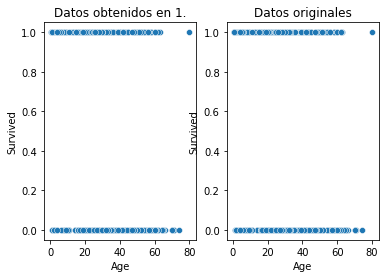

In [12]:
# Creamos la nueva BDD de testeo (que es la original):
data2 = pd.read_csv("data/bd_titanic.csv", sep=",")

# Graficamos en un scatterplot:

fig, axs = plt.subplots(ncols=2)
sns.scatterplot(y='Survived', x='Age', data=data, ax=axs[0]).set(title='Datos obtenidos en 1.')
sns.scatterplot(y='Survived', x='Age', data=data2, ax=axs[1]).set(title='Datos originales')
plt.show()

Podemos notar de los gráficos anteriores que la diferencia pasa prácticamente desapercibida; en los datos modificados en 1 y en los datos originales se tienen relaciones semejantes, por lo que el trabajo con los NaN en 1 fue, a priori, correcto. Ahora bien, observando los datos originales podemos notar que a medida que los años aumentan (a medida que aumenta el valor en el eje y), menos es la proporción de sobrevivientes respecto a la que no pudo sobrevivir, es decir, **la edad permite explicar la sobrevivencia a partir de una relación inversamente proporcional**. Podemos comprobar esta relación mediante una regresión lineal simple:

In [13]:
# Creamos la variable dependiente (sobrevivencia) y la variable inddependiente (edad):
x_reg = data['Age']
y_reg = data['Survived']

# Calculamos la pendiente de la recta:
beta_reg = np.cov(x_reg, y_reg)[0][1]/np.var(x_reg)
beta_reg  # Nos da un valor negativo!

-0.003000465000452129

De esta manera, el coeficiente de regresión estimado es negativo, lo que indica la relación inversa mencionada anteriormente. Lo anterior permite enunciar la primera hipótesis:
<center>
Hipótesis 1: Mientras mayor es la edad de las personas, menor será la sobrevivencia
<center>

En segundo lugar, es importante destacar que, de acuerdo a la época y al contexto, las personas de primera clase, así como las personas de género femenino y niños se les permitía evacuar antes el Titanic, por lo que su sobrevivencia debía ser mayor al de una persona que no cumpla con estas características. Esto en parte fue teorizado anteriormente, con la hipótesis 1. Ahora es el turno de estudiar la relación de las clases y el género con la sobrevivencia:

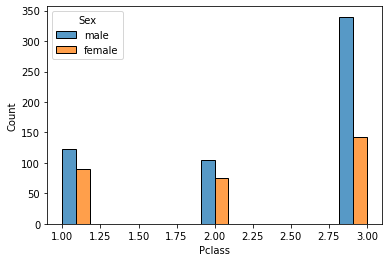

In [14]:
# Graficamos el histograma de las clases del ticket de pasajero:
sns.histplot(data=data, x='Pclass', hue='Sex', multiple='dodge')
plt.show()

Con el gráfico anterior notamos dos cosas importantes: Primero que hay más hombres que mujeres para las clases, y segundo que la cantidad de personas por clase en orden descendente es Tercera, Primera, Segunda clase. Además, la cantidad de personas de la primera y segunda clase es parecida, por lo que podemos comparar la sobrevivencia a partir de ellas:

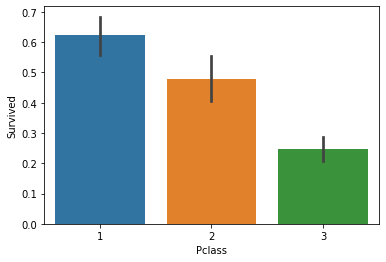

In [15]:
# Comparamos la supervivencia de las 3 clases:
sns.barplot(x='Pclass', y='Survived', data=data)
plt.show()

Por el gráfico anterior notamos que la primera clase tiene mayor probabilidad de sobrevivencia (de acuerdo al barplot) en relación a las otras clases. Más aún, la segunda clase tiene una cantidad de personas parecidas, por lo que si no existiese una relación entre las clases y la sobreviencia los gráficos deberían ser parecidos, pero no es así. Esto permite enunciar nuestra segunda hipótesis:

<center>
Hipótesis 2: A medida que más se pague por las clases, es decir, mientras menor sea el número asociado a la clase del ticket de pasajero, entonces la sobrevivencia será mayor.
<center>

Finalmente realizamos el mismo análisis pero para el género:

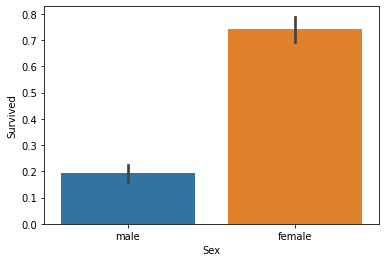

In [16]:
# Comparamos la supervivencia de los 2 géneros
sns.barplot(x='Sex', y='Survived', data=data)
plt.show()

Notamos que en este caso la diferencia es aún mayor que con las clases, lo que finalmente conlleva a la tercera hipótesis:

<center>
Hipótesis 3: El género condiciona radicalmente la sobrevivencia de la persona. Así, si se es mujer, se tendrá mayor probabilidad de sobrevivencia que si se es hombre.
<center>

### Actividad 3: Visualización de los datos

Anteriormente ya revisamos algunas variables (como edad, sexo y tipo de clase). A continuación se presentarán cuatro gráficos asociados a cuatro variables distintas y su utilidad en la estimación:

##### Fare: La tarifa del ticket pagada por el pasajero.

Ya sabemos que la relación entre el precio pagado y la clase obtenida es directa y concluyente, sin embargo, no sabemos cuánto varían los precios. Esto es importante porque si los precios varían en un rango pequeño, entonces la información entregada por la columna ```Fare``` es equivalente a la entregada por la clase obtenida del pasajero:

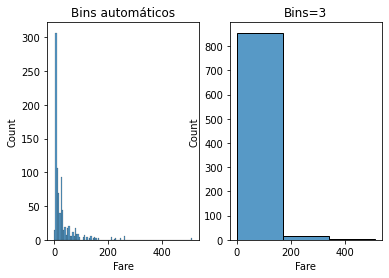

In [17]:
# Obtenemos un histplot del precio pagado por pasajero
fig, axs = plt.subplots(ncols=2)
sns.histplot(x='Fare', data=data, ax=axs[0]).set(title='Bins automáticos')
sns.histplot(x='Fare', data=data, ax=axs[1], bins=3).set(title='Bins=3')
plt.show()

Podemos notar con el histograma que los precios fluctúan bastante, y la gran mayoría obtuvo gratis el pasaje. Además, con 3 separaciones se pueden obtener 3 intervalos donde el precio pagado fluctúa de manera semejante. Esto será de utilidad para discretizar las variables continuas, como lo es esta variable. De esta manera, definimos ```LowPay``` si 0 < ```Fare``` <= 180, ```MediumPay``` si 180 < ```Fare``` <= 350 y ```HighPay``` si ```Fare``` > 350. Para ello se crea la columna ```FareCat```, siguiendo la misma lógica que con los años.

In [18]:
# Se agrega una nueva columna llamada FareCat (Fare categóricos)
data['FareCat'] = pd.cut(data.Fare,bins=[-1, 180, 350, 10000],labels=["LowPay", "MediumPay", "HighPay"])
data.head()

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,AgeCat,FareCat
0,S,3,male,22.0,1.0,0.0,7.2500,0.0,Adultos,LowPay
1,C,1,female,38.0,1.0,0.0,71.2833,1.0,Adultos,LowPay
2,S,3,female,26.0,0.0,0.0,7.9250,1.0,Adultos,LowPay
3,S,1,female,35.0,1.0,0.0,53.1000,1.0,Adultos,LowPay
4,S,3,male,35.0,0.0,0.0,8.0500,0.0,Adultos,LowPay


#### SibSp: La cantidad de hermanos(as) y/o parejas del pasajero que iban en el viaje.

La idea de presentar la cantidad de parientes cercanos (como hermanes y/o parejas) que iban en el viaje es comprender la cercanía de las personas con los pasajeros. Así, es esperable que si va una pareja/hermane en el viaje, entonces al compararlo con personas que van solas se esperaría que los que tienen parientes busquen salvarse entre todos, a diferencia de los que van solos, que buscan salvarse a sí mismos. Esto se ve en el siguiente gráfico:

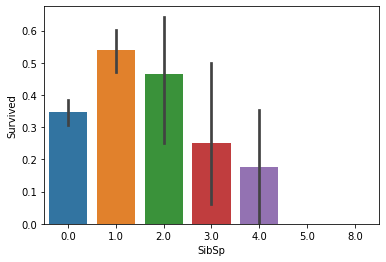

In [19]:
# Comparamos la supervivencia por parientes
sns.barplot(x='SibSp', y='Survived', data=data)
plt.show()

De esta manera, se puede apreciar que mientras más parientes cercanos se tiene, menor es la probabilidad de sobrevivir, justamente por la preocupación que se tiene a la otra persona!

#### Parch: La cantidad de padres y/o hijos(as) del pasajero que iban en el viaje.

Es un análisis similar al anterior, pero ahora la relación tiende a ser más potente, por lo que se esperaría que la diferencia sea aún mayor.

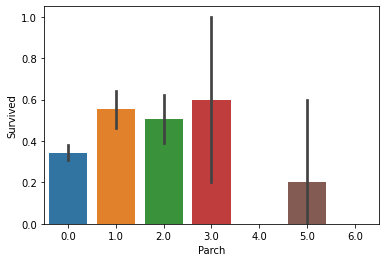

In [20]:
# Comparamos la supervivencia por parientes cercanísimos
sns.barplot(x='Parch', y='Survived', data=data)
plt.show()

En este caso podemos notar algo importante: no ocurre la relación que ocurría con los casos anteriores de parientes. Una posible causa de esto es que la variable relaciona padres con hijos, y viceversa, por lo que dentro de esta categoría se incluyen hijos que tienen a padres, y ya fue visto anteriormente que es esperable que los niños (más probable de que vayan con padres) tiendan una sobrevivencia mayor.

#### Embarked: Puerto donde embarcó el pasajero.

Similar a los casos anteriores, es importante relacionar el puerto del pasajero con su sobrevivencia. En particular es esperable que esto no afecte la sobrevivencia de las personas a menos que la cantidad sea dispareja.

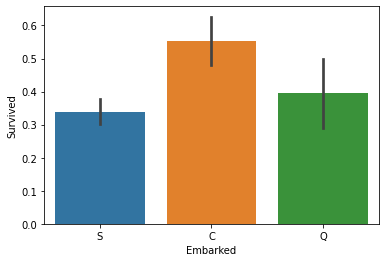

In [21]:
# Comparamos la supervivencia por puerto de llegada
sns.barplot(x='Embarked', y='Survived', data=data)
plt.show()

Podemos notar que para Southampton (S) y Queenstown (Q) la sobrevivencia es parecida, pero para Cherbourg (C) la sobrevivencia es mayor. Esto podría deberse quizás a la cantidad de datos. A continuación se presenta la cantidad de datos de cada categoría:

In [22]:
data['Embarked'].value_counts()

S    633
C    166
Q     76
Name: Embarked, dtype: int64

Notamos que S y Q tienen la mayor y menor cantidad de apariciones respectivamente, lo que indica que algo tuvo que ocurrir con la gente proveniente de C, ya que siendo más que Q sobrevivieron más, va contra la intuición! Para entender de mejor manera ello podríamos utilizar una variable que ya sabemos cómo funciona su sobrevivencia a priori: el género.

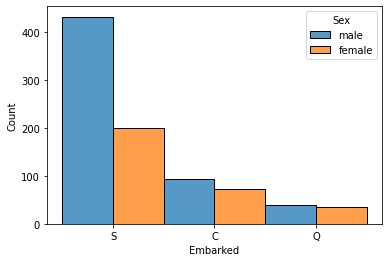

In [23]:
# Graficamos el histograma de los puertos de proveniencia, separados por género
sns.histplot(data=data, x='Embarked', hue='Sex', multiple='dodge')
plt.show()

Ahora notamos algo que nos hace más sentido: En S son más personas embarcadas, pero también más hombres, por lo que su sobrevivencia promedio debería ser mayor! (Asumiendo las hipótesis vistas antes), en tanto en C y Q la cantidad de hombres y mujeres es pareja, lo que indicaría una sobrevivencia más pareja. Para una mejor diferencia podemos también distinguir las clases:

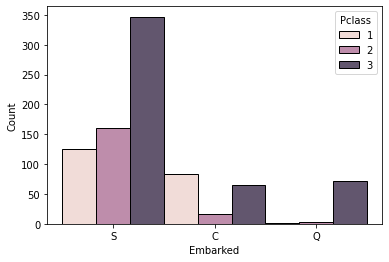

In [24]:
# Graficamos el histograma de las clases del ticket de pasajero:
sns.histplot(data=data, x='Embarked', hue='Pclass', multiple='dodge')
plt.show()

De esta manera, es notorio que en C la mayoría de la gente está en la clase 1, en tanto en Q la mayoría está en la clase 3. Asumiendo las hipótesis presentadas antes, la gente proveniente de C tiende a sobrevivir más, justamente por la clase mayoritaria, y esto es lo que intentábamos explicar anteriormente.

### Actividad 4: Pre-procesamiento de los datos

Comenzamos visualizando nuevamente la base de datos, para tener una idea de qué debemos hacer:

In [25]:
data.head()

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,AgeCat,FareCat
0,S,3,male,22.0,1.0,0.0,7.2500,0.0,Adultos,LowPay
1,C,1,female,38.0,1.0,0.0,71.2833,1.0,Adultos,LowPay
2,S,3,female,26.0,0.0,0.0,7.9250,1.0,Adultos,LowPay
3,S,1,female,35.0,1.0,0.0,53.1000,1.0,Adultos,LowPay
4,S,3,male,35.0,0.0,0.0,8.0500,0.0,Adultos,LowPay


Así como la frecuencia de cada variable:

In [26]:
data.nunique()

Embarked      3
Pclass        3
Sex           2
Age          89
SibSp         7
Parch         7
Fare        245
Survived      2
AgeCat        3
FareCat       3
dtype: int64

Se realizarán entonces las siguientes separaciones:
* Las variables ```Embarked, Pclass, Sex, AgeCat, FareCat``` serán numerizadas a 0 o 1 según el tipo.
* Las variables ```Age``` y ```Fare``` serán eliminadas, dado que su información está representada en ```AgeCat``` y ```FareCat``` respectivamente (no fueron eliminadas anteriormente para el análisis previo solamente).
* Las variables ```SibSp``` y ```Parch``` serán categorizadas en 0 o distinto de 0 de acuerdo a la variable, y categorizándola inmediatamente. Así, por ejemplo, si se tienen más de 0 hermanes/pareja, entonces ```SibSp``` será 1. Si se tienen 0 de aquellos, la variable será 0. Al igual que con ```Age``` y ```Fare```, estas variables no fueron trabajadas anteriormente para el análisis!

Procedemos a realizar lo mencionado en el orden que se presentó:

In [27]:
# Embarked, Pclass, Sex, AgeCat, FareCat numerizadas:
data = pd.get_dummies(data, columns=["Embarked", "Pclass", "Sex", "AgeCat", "FareCat"])

# Age y Fare eliminadas:
data = data.drop(labels=["Age", "Fare"], axis=1)

# SibSp y Parch categorizadas y numerizadas:
data['SibSp'] = pd.cut(data.SibSp,bins=[-1, 0.1, 1000],labels=[0, 1])
data['Parch'] = pd.cut(data.Parch,bins=[-1, 0.1, 1000],labels=[0, 1])
data.head()

,SibSp,Parch,Survived,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,AgeCat_Niños,AgeCat_Adultos,AgeCat_AdultosAncianos,FareCat_LowPay,FareCat_MediumPay,FareCat_HighPay
0,1,0,0.0,0,0,1,0,0,1,0,1,0,1,0,1,0,0
1,1,0,1.0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,0,0,1.0,0,0,1,0,0,1,1,0,0,1,0,1,0,0
3,1,0,1.0,0,0,1,1,0,0,1,0,0,1,0,1,0,0
4,0,0,0.0,0,0,1,0,0,1,0,1,0,1,0,1,0,0


Una vez numerizadas todas las categorías de interés, comenzamos dividiendo la BDD en la matriz de Características y la de Etiquetas:

In [28]:
# Matriz de Características:
X_data = data.loc[:, data.columns != 'Survived']

# Matriz de Etiquetas:
y_data = data['Survived']

In [29]:
# Las visualizamos:
X_data

,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,AgeCat_Niños,AgeCat_Adultos,AgeCat_AdultosAncianos,FareCat_LowPay,FareCat_MediumPay,FareCat_HighPay
0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0
1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0
3,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0
4,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0
887,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0
888,1,1,0,0,1,0,0,1,1,0,0,1,0,1,0,0
889,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0


In [30]:
y_data

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 875, dtype: float64

Ahora que tenemos separados los datos, podemos generar nuestros sets de entrenamiento, validación y testeo. Comenzamos importando las librerías necesarias (Código muy basado en la ayudantía 8):

In [31]:
from sklearn.model_selection import train_test_split

Ahora separamos el set de entrenamiento. Es importante notar que la proporción del set de entrenamiento es mejor mientras más balanceado sea. Por lo anterior, a continuación se visualiza el balance en los set de entrenamiento para la variable ```Survived``` de acuerdo a la proporción:

In [32]:
proporciones = np.linspace(0.1,0.9,9)  # Proporciones de 0 a 1 con 1 décima de diferencia
y_train_prop = []  # Lista que contiene los y_train para cada proporción

# Contienen los X,y train para cada proporción
y_train_finale = []
X_train_finale = []
for i in proporciones:
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=1-i, random_state=4445465)
    y_train_prop.append((y_train.value_counts()[0],y_train.value_counts()[1]))

    y_train_finale.append([y_train, y_test])
    X_train_finale.append([X_train, X_test])


for i in range(9):
    print(f'Balanceo para proporción {np.round(proporciones[i],decimals=1)}: {y_train_prop[i]}, con proporción de 0s y 1s igual a {np.round(y_train_prop[i][0]/(y_train_prop[i][0]+y_train_prop[i][1]), decimals=2)} - {np.round(y_train_prop[i][1]/(y_train_prop[i][0]+y_train_prop[i][1]), decimals=2)}')

Balanceo para proporción 0.1: (51, 36), con proporción de 0s y 1s igual a 0.59 - 0.41
Balanceo para proporción 0.2: (105, 70), con proporción de 0s y 1s igual a 0.6 - 0.4
Balanceo para proporción 0.3: (159, 103), con proporción de 0s y 1s igual a 0.61 - 0.39
Balanceo para proporción 0.4: (214, 136), con proporción de 0s y 1s igual a 0.61 - 0.39
Balanceo para proporción 0.5: (270, 167), con proporción de 0s y 1s igual a 0.62 - 0.38
Balanceo para proporción 0.6: (323, 202), con proporción de 0s y 1s igual a 0.62 - 0.38
Balanceo para proporción 0.7: (376, 236), con proporción de 0s y 1s igual a 0.61 - 0.39
Balanceo para proporción 0.8: (432, 268), con proporción de 0s y 1s igual a 0.62 - 0.38
Balanceo para proporción 0.9: (478, 309), con proporción de 0s y 1s igual a 0.61 - 0.39


Puede notarse a simple vista que todas las proporciones generan un balance del tipo 60-40%. **Escogeremos entonces la proporción igual al 70% de los datos**, de manera que se tenga aproximadamente 61% de los datos iguales a 0 y 39% de los datos iguales a 1 para la variable ```Survived```

In [33]:
# Actualizamos los sets de entrenamiento a lo que nos interesa:
X_train = X_train_finale[6][0]
y_train = y_train_finale[6][0]

In [34]:
# Visualizamos los sets:
X_train.head()

,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,AgeCat_Niños,AgeCat_Adultos,AgeCat_AdultosAncianos,FareCat_LowPay,FareCat_MediumPay,FareCat_HighPay
249,1,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0
772,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0
283,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0
262,1,1,0,0,1,1,0,0,0,1,0,0,1,1,0,0
568,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0


In [35]:
y_train.head()

249    0.0
772    0.0
283    1.0
262    0.0
568    0.0
Name: Survived, dtype: float64

Ahora se presentarán los sets de testeo y validación según un porcentaje de 20% y 10% de los datos originales (```X_data, y_data```) respectivamente, o lo que es lo mismo, 2/3 y 1/3 respectivamente del set (```X_test```, ```y_test```) generado anteriormente:

In [36]:
X_test, X_validation, y_test, y_validation = train_test_split(X_train_finale[6][1], y_train_finale[6][1], test_size=1/3, random_state=10)

In [37]:
# Visualizamos los datos:
X_test.head()

,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,AgeCat_Niños,AgeCat_Adultos,AgeCat_AdultosAncianos,FareCat_LowPay,FareCat_MediumPay,FareCat_HighPay
58,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0
42,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0
586,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0
502,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0
537,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0


In [38]:
y_test.head()

58     1.0
42     0.0
586    0.0
502    0.0
537    1.0
Name: Survived, dtype: float64

In [39]:
X_validation.head()

,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,AgeCat_Niños,AgeCat_Adultos,AgeCat_AdultosAncianos,FareCat_LowPay,FareCat_MediumPay,FareCat_HighPay
573,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0
546,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0
29,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0
313,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0
756,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0


In [40]:
y_validation.head()

573    1.0
546    1.0
29     0.0
313    0.0
756    0.0
Name: Survived, dtype: float64

De esta manera, podemos notar la cantidad de instancias para cada categoría de ```Survived``` hay en cada set:

In [41]:
print(f'Para el set de entrenamiento (y_train), tenemos {y_train.value_counts()[0]} instancias de valor 0, y {y_train.value_counts()[1]} instancias de valor 1')
print(f'Para el set de testeo (y_test), tenemos {y_test.value_counts()[0]} instancias de valor 0, y {y_test.value_counts()[1]} instancias de valor 1')
print(f'Para el set de validación (y_validation), tenemos {y_validation.value_counts()[0]} instancias de valor 0, y {y_validation.value_counts()[1]} instancias de valor 1')

Para el set de entrenamiento (y_train), tenemos 376 instancias de valor 0, y 236 instancias de valor 1
Para el set de testeo (y_test), tenemos 109 instancias de valor 0, y 66 instancias de valor 1
Para el set de validación (y_validation), tenemos 53 instancias de valor 0, y 35 instancias de valor 1


Las proporciones utilizadas para cada set ya fueron mencionadas, pero se resumen a continuación:
* Para el set de entrenamiento se eligió una proporción del 70% de los datos originales, ya que eran lo que generaban el mayor balanceo para los datos.
* Para el set de testeo se eligió una proporción del 20% de los datos originales, ya que equivale a un porcentaje superior al 50% del 30% restante (y en general, se busca que el set de testeo sea de mayor tamaño que el de validación).
* Para el set de validación se eligió una proporción del 10% de los datos originales, por una razón complementaria a la explicada en el paso anterior.

Se pudo comprobar anteriormente que este balanceo es el mejor que se puede obtener de acuerdo a los datos y la cantidad de datos útil para los sets. Aún así, el balanceo no es lo mejor que se puede tener, ya que sigue existiendo una gran parte de los datos con valor 0 (no es un balanceo perfecto, pero si aceptable).

Si las categorías están mal balanceadas, entonces podría ocurrir que el modelo estime con un accuracy muy alto, pero solamente porque fue entrenado con la mayoría de datos en una sola categoría. En este caso, el accuracy no sería una métrica válida para sacar conclusiones.

### Actividad 5: Entrenando un árbol de decisión

Comenzamos importando las librerías que utilizaremos:

In [42]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

In [43]:
# Instanciamos el Árbol de decisión:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=9)

# Entrenamos el árbol según los sets de entrenamiento:
dtc.fit(X_train, y_train)

# Como ya fue entrenado, predecimos datos de acuerdo al set de entrenamiento, testeo y validación:
y_predict_train = dtc.predict(X_train)
y_predict_test = dtc.predict(X_test)
y_predict_val = dtc.predict(X_validation)

# Calculamos el accuracy:
print(f'Accuracy para el set de entrenamiento: {metrics.accuracy_score(y_train, y_predict_train)}')
print(f'Accuracy para el set de test: {metrics.accuracy_score(y_test, y_predict_test)}')
print(f'Accuracy para el set de validación: {metrics.accuracy_score(y_validation, y_predict_val)}')

Accuracy para el set de entrenamiento: 0.8513071895424836
Accuracy para el set de test: 0.8457142857142858
Accuracy para el set de validación: 0.7954545454545454


Se puede apreciar que en todos los sets anteriores el accuracy es bastante bueno y semejante. Más aún, en el set de testeo se tiene un accuracy muy parecido al set de entrenamiento, por lo que se podría decir que no estamos frente a overfitting! De esta manera, se decide solamente utilizar el criterio de entropía y un máximo de profundidad de 9.

### Actividad 6: Ensamblaje personalizado básico

Creamos la clase ```CustomRandomForest```:

In [44]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder

# Codificador para el método predict:
encoder = LabelEncoder()

class CustomRandomForest:

    def __init__(self, w1=None, w2=None, w3=None, criterion="entropy", max_depth=None):
        # Ponderadores:
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

        # Árboles:
        self.A1 = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)  # Cambiar hyper-parámetros directamente aquí
        self.A2 = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)  # Cambiar hyper-parámetros directamente aquí
        self.A3 = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)  # Cambiar hyper-parámetros directamente aquí

        # Las siguientes son variables que determinan si cada arbol fue o no fue entrenado:
        self.A1_trained = False  # Si es entrenado, entonces cambiar a True
        self.A2_trained = False  # Si es entrenado, entonces cambiar a True
        self.A3_trained = False  # Si es entrenado, entonces cambiar a True

    def subdata_trained(self, A, X_train, y_train):
        """
        Este método recibe un árbol de decisión entrenado, el set de entrenamiento X y retorna otro set de
        entrenamiento Y que contiene únicamente aquellas instancias donde la predicción del árbol de decisión
        entrenado por X falla.
        """
        # Guardamos el valor predicho por A:
        y_predict_A = A.predict(X_train)
        # Ahora, los nuevos sets de entrenamiento son calculados por los fallos de A:
        failed_A = []  # Lista que contiene el índice donde ocurren fallos de predicción
        for i in range(len(y_predict_A)):
            if y_predict_A[i] != np.array(y_train)[i]:  # Si existe un fallo
                failed_A.append(i)  # Agrega el índice donde ocurre a la lista

        # Podría ocurrir que A1 logre predecir todo correctamente, en tal caso no existirían los subsets que buscamos retornar
        if len(failed_A) == 0:
            return (0, 0)  # Se retorna 0 si no hay fallos

        # En caso contrario, se continúa:
        # Definimos los nuevos sets de entrenamiento para retornar:
        X_train_A2 = X_train.iloc[failed_A, :]
        y_train_A2 = y_train.iloc[failed_A]

        # Retornamos el árbol entrenado y los sets en forma de tupla:
        return (X_train_A2, y_train_A2)


    def fit(self, X_train, y_train):
        # Entrenamos el árbol A1:
        self.A1.fit(X_train, y_train)
        self.A1_trained = True  # El árbol A1 ya fue entrenado

        # Aprovechamos el método creado anteriormente, de manera que obtenemos el set de entrenamiento
        # para A2 si es que este existe:
        X_train_A2, y_train_A2 = self.subdata_trained(self.A1, X_train, y_train)

        # Si no existe el set de entrenamiento para A2 es porque se predijo todo correctamente en A1:
        if not isinstance(X_train_A2, pd.core.frame.DataFrame):
            return

        # Para A2, el procedimiento es análogo al árbol A1:
        # Entrenamos el árbol A2, notar que utilizamos los nuevos sets de entrenamiento:
        self.A2.fit(X_train_A2, y_train_A2)
        self.A2_trained = True  # El árbol A2 ya fue entrenado

        # Aprovechamos el método creado anteriormente, de manera que obtenemos el set de entrenamiento 
        # para A3 si es que este existe.
        X_train_A3, y_train_A3 = self.subdata_trained(self.A2, X_train_A2, y_train_A2)

        # Si no existe el set de entrenamiento para A3 es porque se predijo todo correctamente en A2:
        if not isinstance(X_train_A3, pd.core.frame.DataFrame):
            # Por lo tanto, el set de entrenamiento para A3 será el mismo que para A2:
            # Entrenamos el árbol A3:
            self.A3.fit(X_train_A2, y_train_A2)
            self.A3_trained = True  # El árbol A3 ya fue entrenado

        # Si no se predijo todo correctamente en A2, entonces debe ser la concatenación de ambos sets:
        else:
            # Hacemos una copia del set generado por A1:
            X_train_A2_copy = X_train_A2.copy()
            y_train_A2_copy = pd.DataFrame(y_train_A2.copy())
            
            # Se le añade la columna con los índices, para así eliminar datos iguales en la concatenación,
            # pero necesariamente de distintas columnas
            X_train_A2_copy['ind'] = X_train_A2.index
            y_train_A2_copy['ind'] = y_train_A2.index

            # Se homologa para el otro DataFrame:
            X_train_A3_copy = X_train_A3.copy()
            y_train_A3_copy = pd.DataFrame(y_train_A3.copy())
            
            # Se le añade la columna con los índices, para así eliminar datos iguales en la concatenación,
            # pero necesariamente de distintas columnas
            X_train_A3_copy['ind'] = X_train_A3.index
            y_train_A3_copy['ind'] = y_train_A3.index

            X_train_A3_final = pd.concat([X_train_A2_copy, X_train_A3_copy]).drop_duplicates().reset_index(drop=False)
            X_train_A3_final = X_train_A3_final.drop(['ind'], axis=1)
            y_train_A3_final = pd.concat([y_train_A2_copy, y_train_A3_copy]).drop_duplicates().reset_index(drop=False)
            y_train_A3_final = y_train_A3_final.drop(['ind'], axis=1)
            y_train_A3_final = y_train_A3_final[y_train_A3_final.columns[0]]

            # Entrenamos el árbol A3:
            self.A3.fit(X_train_A3_final, y_train_A3_final)
            self.A3_trained = True  # El árbol A3 ya fue entrenado

        # Como no se pide nada a partir de A3, se termina la ejecución
        return

    def predict(self, X):
        # Guardamos las dimensiones de X:
        n = X.shape[0]

        # Se comienza calculando la probabilidad para cada árbol:
        # Para el árbol A1:
        prob_A1 = self.A1.predict_proba(X)

        # Para el árbol A2, debe considerarse si fue o no fue entrenado. Ya sabemos que si
        # A1 predice todo correctamente, A2 no fue entrenado.
        # En caso que si haya sido entrenado:
        if self.A2_trained:
            prob_A2 = self.A2.predict_proba(X)

            # Para el árbol A3, debe considerarse si fue o no fue entrenado. Ya sabemos que si
            # A2 fue entrenado, entonces A3 también lo fue
            # En caso que si haya sido entrenado:
            prob_A3 = self.A3.predict_proba(X)

        # En caso que NO haya sido entrenado:
        else:
            prob_A2 = np.zeros((n,2))

            # Por construcción, sabemos que si A2 no fue entrenado, A3 tampoco lo fue
            prob_A3 = np.zeros((n,2))

            # Se actualizan los valores de w:
            self.w1 = 1
            self.w2 = 0
            self.w3 = 0

        # Ahora hacemos la asignación del ensamble:
        weighted_prob = prob_A1*self.w1 + prob_A2*self.w2 + prob_A3*self.w3
        # Es un numpy array de la forma [[prob0_1, prob1_1], [prob0_2, prob1_2], ...] con prob_j_i ponderado!
        # Ahora comparamos por filas; si en una fila i, el elemento de la izquierda tiene un valor mayor al elemento de la derecha,
        # entonces se debe agregar a la fila i de la serie objetivo un 0. En caso contrario, se agrega un 1.
        # Comenzamos con el trabajo de datos; En primer lugar, separamos las columnas de weighted_prob. En particular,
        # nos interesa la columna de la derecha (de índice 1) ya que es la que contiene los valores igual a 1 y la usaremos luego:
        weighted_prob_1 = np.hsplit(weighted_prob, 2)[1].reshape((n,))  # Ahora es un numpy array!
        
        # En segundo lugar, obtenemos el máximo de feature en cada fila de weighted_prob. Así, se crea un numpy array
        # que siempre contiene al "ganador":
        winner = np.amax(weighted_prob, axis=1)

        # En tercer lugar, deseamos comparar cada elemento de weighted_prob_1 con cada elemento de winner. Si los elementos
        # son iguales, entonces el valor es True, si son distintos, el valor es False. Esto se hace porque si el máximo (ganador)
        # es igual a un valor de probabilidad asociado ala categoría 1, entonces se dice que gana la categoría 1. Si
        # el valor es distinto, gana la categoría 0.
        comparative = np.equal(weighted_prob_1, winner)  # Un numpy array de True's y False's!

        # En cuarto lugar, se numerizan los True y False de comparative, a 1's y 0's respectivamente:
        comparative = encoder.fit_transform(comparative)

        # Finalmente, por formato y enunciado, se transforma el array comparative a una serie:
        comparative = pd.Series(comparative)
        return comparative

Respecto al código anterior, se tomaron las siguientes consideraciones:
* Si A1 logra correr todo el set de entrenamiento perfectamente, entonces A2 y A3 no se entrenan, ya que no existe set de entrenamiento derivado de A1 para ellos.
* Bajo el caso que A2 (y por ende, A3) no haya sido entrenado, entonces se tomará su probabilidad de predicción en ambas categorías como una columna de 0's del mismo tamaño que el predict logrado en A1.
* Bajo el caso que A2 y A3 no hayan sido entrenados, los valores de w asociado a cada árbol serán reemplazados. En particular, el único caso que puede suceder es que solamente A1 haya sido entrenado, por lo tanto se actualizan los valores de w según w1 = 1, w2,3 = 0.

A continuación se entrena el modelo y se obtienen estadísticas:

In [45]:
# Instanciamos el ensamble:
custom_rfc = CustomRandomForest(w1=0.8, w2=0.1, w3=0.1)

# Entrenamos el ensamble según los sets de entrenamiento:
custom_rfc.fit(X_train, y_train)

# Como ya fue entrenado, predecimos datos de acuerdo al set de entrenamiento, testeo y validación:
y_predict_train_rfcC = custom_rfc.predict(X_train)
y_predict_test_rfcC = custom_rfc.predict(X_test)
y_predict_val_rfcC = custom_rfc.predict(X_validation)

# Calculamos el accuracy:
print(f'Accuracy para el set de entrenamiento: {metrics.accuracy_score(y_train, y_predict_train_rfcC)}')
print(f'Accuracy para el set de test: {metrics.accuracy_score(y_test, y_predict_test_rfcC)}')
print(f'Accuracy para el set de validación: {metrics.accuracy_score(y_validation, y_predict_val_rfcC)}')

Accuracy para el set de entrenamiento: 0.8447712418300654
Accuracy para el set de test: 0.8285714285714286
Accuracy para el set de validación: 0.8068181818181818


En todos los sets anteriores el accuracy es bastante bueno. Además, interesa saber cuáles árboles fueron entrenados realmente:

In [46]:
# Árboles entrenados:
print(f'¿Fue el árbol A1 entrenado?: {custom_rfc.A1_trained}')
print(f'¿Fue el árbol A2 entrenado?: {custom_rfc.A2_trained}')
print(f'¿Fue el árbol A3 entrenado?: {custom_rfc.A3_trained}')

¿Fue el árbol A1 entrenado?: True
¿Fue el árbol A2 entrenado?: True
¿Fue el árbol A3 entrenado?: True


De esta manera, todos los árboles fueron entrenados!

### Actividad 7: Entrenando un Random Forest

Comenzamos importando las librerías:

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Instanciamos el Random Forest
rfc = RandomForestClassifier(criterion="entropy")

# Entrenamos el Forest según los sets de entrenamiento:
rfc.fit(X_train, y_train)

# Como ya fue entrenado, predecimos datos de acuerdo al set de entrenamiento, testeo y validación:
y_predict_train_rfc = rfc.predict(X_train)
y_predict_test_rfc = rfc.predict(X_test)
y_predict_val_rfc = rfc.predict(X_validation)

# Calculamos el accuracy:
print(f'Accuracy para el set de entrenamiento: {metrics.accuracy_score(y_train, y_predict_train_rfc)}')
print(f'Accuracy para el set de test: {metrics.accuracy_score(y_test, y_predict_test_rfc)}')
print(f'Accuracy para el set de validación: {metrics.accuracy_score(y_validation, y_predict_val_rfc)}')

Accuracy para el set de entrenamiento: 0.8513071895424836
Accuracy para el set de test: 0.8514285714285714
Accuracy para el set de validación: 0.7954545454545454


### Final:

Primero importamos las librerías que utilizaremos:

In [49]:
from sklearn import tree

In [50]:
# Graficamos el árbol según el código de https://mljar.com/blog/visualize-decision-tree/
fig = plt.figure(figsize=(150,140))
_ = tree.plot_tree(dtc, 
                   feature_names=X_train.columns,  
                   class_names='Survived',
                   filled=True)
plt.show()

Podemos notar que el tamaño de imagen es suficientemente grande como para que con un zoom se pueda visualizar cada hoja (para usar el zoom, depende de dónde se esté ejecutando el jupyter :( en caso de usar VSCode, se implementa automáticamente!). Por la imagen se puede ver que el nodo principal (el de más arriba) es el de si es hombre o mujer!

La lectura se realiza según fue especificada en https://stackoverflow.com/questions/23557545/how-to-explain-the-decision-tree-from-scikit-learn: Se lee la primera linea del nodo hoja, esta es una condición. Si se cumple, se elige el nodo de la izquierda, si no se cumple, se elige el de la derecha.

A continuación creamos dos pasajeros ficticios:
* Pasajero 1: Buscamos que sea muy diferente a la época!: Que tenga 4 hermanos y 3 parejas; que no viaje con los padres ni tenga hijos; Que haya embarcado en Southampton y pague la primera clase; que sea hombre y adulto, pero que se haya ganado el pasaje por lotería, por lo que no se haya pagado nada por él.

In [51]:
# Se crea el pasajero 1 según lo descrito anteriormente:
pasajero_1 = {'SibSp': 1,
              'Parch': 0,
              'Embarked_C': 0,
              'Embarked_Q': 0,
              'Embarked_S': 1,
              'Pclass_1': 1,
              'Pclass_2': 0,
              'Pclass_3': 0,
              'Sex_female': 0,
              'Sex_male': 1,
              'AgeCat_Niños': 0,
              'AgeCat_Adultos': 1,
              'AgeCat_AdultosAncianos': 0,
              'FareCat_LowPay': 1,
              'FareCat_MediumPay': 0,
              'FareCat_HighPay': 0}
pasajero_1_df = pd.DataFrame(pasajero_1, index=[0])
pasajero_1_df

,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,AgeCat_Niños,AgeCat_Adultos,AgeCat_AdultosAncianos,FareCat_LowPay,FareCat_MediumPay,FareCat_HighPay
0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0


Ahora podemos seguir el arbol graficado anteriormente. Los pasos seguidos desde el nodo principal son los siguientes:
* 1. Sex_male <= 0.5 no se cumple -> se elige el nodo de la derecha.
* 2. Pclass_1 <= 0.5 no se cumple -> se elige el nodo de la derecha.
* 3. AgeCat_AdultosAncianos <= 0.5 se cumple -> se elige el nodo de la izquierda.
* 4. FareCat_MediumPay <= 0.5 se cumple -> se elige el nodo de la izquierda.
* 5. Embarked_C <= 0.5 se cumple -> se elige el nodo de la izquierda.
* 6. Parch <= 0.5 se cumple -> se elige el nodo de la izquierda.
* 7. Embarked_S <= 0.5 no se cumple -> se elige el nodo de la derecha.
* 8. SibSp <= 0.5 no se cumple -> se elige el nodo de la derecha.
* 9. Notamos que se llegó a un nodo con value = [6, 3], es decir, 6 muestras morirían y 3 muestras sobrevivirían. En este caso, es más probable que el pasajero 1 **muera**!

* Pasajero 2: Ahora buscamos un pasajero común de la época de clase baja: Que tenga 15 hermanos y 0 parejas; que no viaje con los padres y tenga 6 hijos; Que haya embarcado en Cherbourg y pague tercera clase; que sea mujer y adulta-anciana, y haya pagado mucho por el pasaje, ya que era esclava y no le permitían ir a menos que pagase lo que cuesta la primera clase :(

In [52]:
# Se crea el pasajero 2 según lo descrito anteriormente:
pasajero_2 = {'SibSp': 1,
              'Parch': 1,
              'Embarked_C': 1,
              'Embarked_Q': 0,
              'Embarked_S': 0,
              'Pclass_1': 0,
              'Pclass_2': 0,
              'Pclass_3': 1,
              'Sex_female': 1,
              'Sex_male': 0,
              'AgeCat_Niños': 0,
              'AgeCat_Adultos': 0,
              'AgeCat_AdultosAncianos': 1,
              'FareCat_LowPay': 0,
              'FareCat_MediumPay': 0,
              'FareCat_HighPay': 1}
pasajero_2_df = pd.DataFrame(pasajero_2, index=[0])
pasajero_2_df

,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,AgeCat_Niños,AgeCat_Adultos,AgeCat_AdultosAncianos,FareCat_LowPay,FareCat_MediumPay,FareCat_HighPay
0,1,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1


Ahora podemos seguir el arbol graficado anteriormente. Los pasos seguidos desde el nodo principal son los siguientes:
* 1. Sex_male <= 0.5 se cumple -> se elige el nodo de la izquierda.
* 2. Pclass_3 <= 0.5 no se cumple -> se elige el nodo de la derecha.
* 3. Embarked_S <= 0.5 se cumple -> se elige el nodo de la izquierda.
* 4. Parch <= 0.5 no se cumple -> se elige el nodo de la derecha.
* 5. Embarked_C <= 0.5 no se cumple -> se elige el nodo de la derecha.
* 6. SibSp <= 0.5 no se cumple -> se elige el nodo de la derecha.
* 7. Se llega a un nodo con value = [1, 2], es decir, 1 muestra moriría y 2 sobrevivirían. De esta manera, es más probable que el pasajero 2 **sobreviva**

Ahora se realizará la estimación empírica!

In [53]:
prediccion_bonus = dtc.predict(pasajero_1_df.append(pasajero_2_df))
print(f'La supervivencia del pasajero 1 se predijo con valor {prediccion_bonus[0]}')
print(f'La supervivencia del pasajero 2 se predijo con valor {prediccion_bonus[1]}')

La supervivencia del pasajero 1 se predijo con valor 0.0
La supervivencia del pasajero 2 se predijo con valor 1.0


Podemos notar que lo realizado en el ítem anterior es correcto! y el pasajero 1 moriría, en tanto el pasajero 2 sobreviviría!!